In [ ]:
## Download data from Kaggle ##
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)


# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Device: cuda


Enter number of epochs (default 10):  40
Enter batch size (default 64):  32
Enter number of hidden layers (default 3):  3
Enter learning rate (default 0.001):  0.0001


C:\Users\eshaa\anaconda3\envs\MSBA\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40 - Training...
Training Loss: 3.5876
Validation Loss: 3.5817, Accuracy: 0.0627, F1 Score: 0.0101
Best model updated at epoch 1 with accuracy 0.0627
Epoch 2/40 - Training...
Training Loss: 3.5770
Validation Loss: 3.5529, Accuracy: 0.0427, F1 Score: 0.0112
Epoch 3/40 - Training...
Training Loss: 3.5400
Validation Loss: 3.4637, Accuracy: 0.0655, F1 Score: 0.0220
Best model updated at epoch 3 with accuracy 0.0655
Epoch 4/40 - Training...
Training Loss: 3.4864
Validation Loss: 3.3836, Accuracy: 0.0541, F1 Score: 0.0228
Epoch 5/40 - Training...
Training Loss: 3.4315
Validation Loss: 3.2949, Accuracy: 0.0570, F1 Score: 0.0150
Epoch 6/40 - Training...
Training Loss: 3.3804
Validation Loss: 3.2573, Accuracy: 0.0570, F1 Score: 0.0140
Epoch 7/40 - Training...
Training Loss: 3.3396
Validation Loss: 3.2260, Accuracy: 0.0598, F1 Score: 0.0148
Epoch 8/40 - Training...
Training Loss: 3.3172
Validation Loss: 3.2213, Accuracy: 0.0627, F1 Score: 0.0160
Epoch 9/40 - Training...
Training Loss: 3.

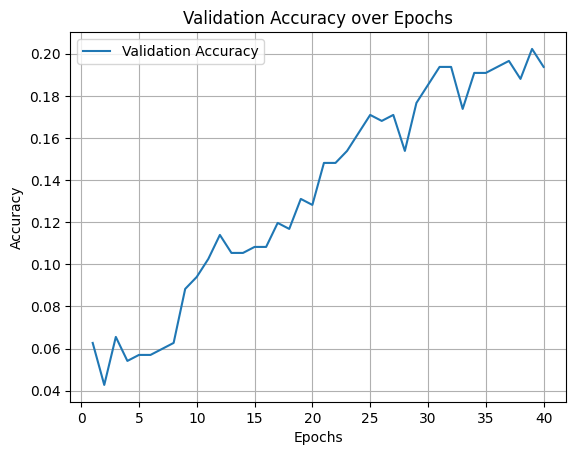

Validation accuracy over epochs graph saved as 'validation_accuracy.png'.


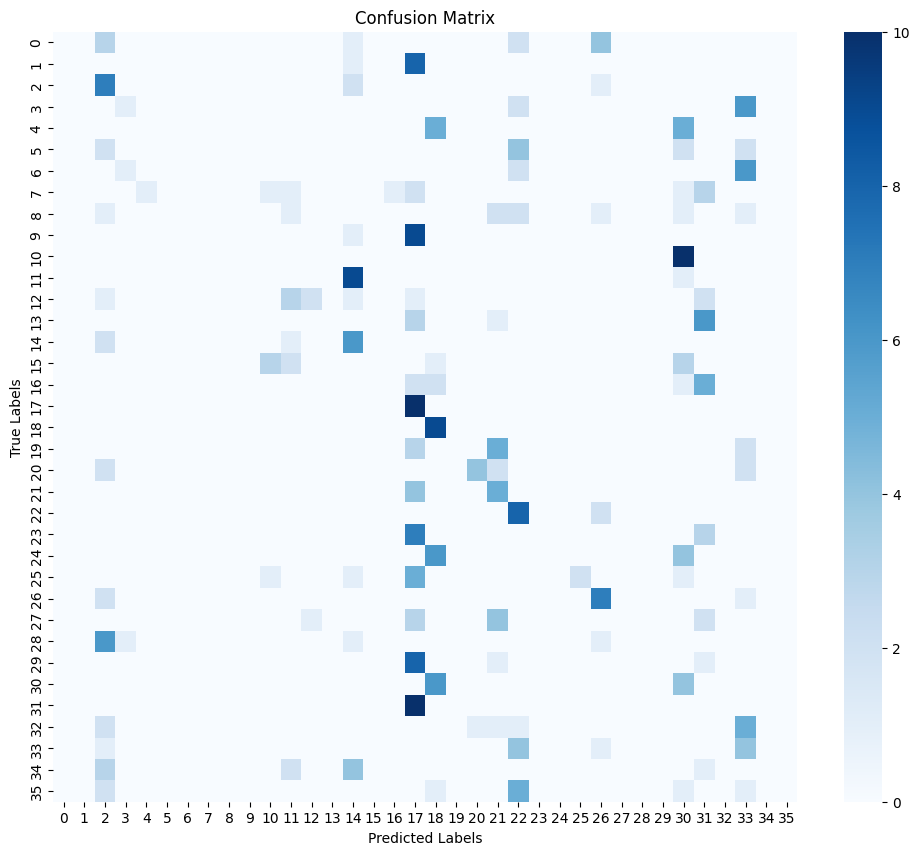

Confusion matrix saved as 'confusion_matrix.png'.
Training Complete!


In [19]:
## Train Model ##
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Paths to dataset
DATASET_PATHS = {
    "train": r"C:\Users\eshaa\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8\train",
    "test": r"C:\Users\eshaa\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8\test",
    "validation": r"C:\Users\eshaa\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8\validation"
}

# Data Prep
def load_dataset1_data(batch_size=64):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Load the training dataset
    train_dataset = datasets.ImageFolder(root=DATASET_PATHS["train"], transform=transform)
    class_names = train_dataset.classes
    num_classes = len(class_names)

    # Check if 'validation' key exists in DATASET_PATHS
    if "validation" in DATASET_PATHS and os.path.exists(DATASET_PATHS["validation"]):
        val_dataset = datasets.ImageFolder(root=DATASET_PATHS["validation"], transform=transform)
    else:
        # Split 10% of the training dataset for val
        val_size = int(0.1 * len(train_dataset))
        train_size = len(train_dataset) - val_size
        generator = torch.Generator().manual_seed(42)  # For reproducibility
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)
        print(f"No validation dataset found. Using {val_size} samples from training data for validation.")

    # Load the test dataset
    test_dataset = datasets.ImageFolder(root=DATASET_PATHS["test"], transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader, num_classes, class_names

# Model Definition
class CNNModel(nn.Module):
    def __init__(self, num_classes, hidden_layers=3):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        classifier_layers = [nn.Flatten()]
        input_size = 128 * 16 * 16  # Ensure this matches the output of features
        for _ in range(hidden_layers):
            classifier_layers.append(nn.Linear(input_size, 128))
            classifier_layers.append(nn.ReLU())
            classifier_layers.append(nn.Dropout(0.5))
            input_size = 128
        classifier_layers.append(nn.Linear(128, num_classes))  # Final layer

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training and Evaluation
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs, class_names, learning_rate, batch_size, hidden_layers):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use user-defined learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=2, factor=0.5, verbose=True)

    best_accuracy = 0.0
    best_model_state_dict = None
    best_epoch = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs} - Training...")
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Training Loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state_dict = model.state_dict()
            best_epoch = epoch + 1
            print(f"Best model updated at epoch {best_epoch} with accuracy {best_accuracy:.4f}")

        # Step the scheduler
        scheduler.step(val_accuracy)

    # Save the model w/ metadata
    model_info = {
        'model_state_dict': best_model_state_dict,
        'num_classes': len(class_names),
        'class_names': class_names,
        'epochs': num_epochs,
        'hidden_layers': hidden_layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size
    }
    torch.save(model_info, 'cnn-ds1-model.pth')
    print("Model saved as 'cnn-ds1-model.pth' with metadata.")

    # Save training metrics to CSV
    metrics_df = pd.DataFrame({
        'Epoch': list(range(1, len(train_losses) + 1)),
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies,
        'Validation F1 Score': val_f1_scores
    })
    metrics_df.to_csv('training_metrics.csv', index=False)
    print("Training metrics saved to 'training_metrics.csv'.")

    # Plot validation accuracy over epochs
    plt.figure()
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig("validation_accuracy.png")
    plt.show()
    print("Validation accuracy over epochs graph saved as 'validation_accuracy.png'.")

    # Load the best model for evaluation
    model.load_state_dict(best_model_state_dict)

    # Compute confusion matrix on validation set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Confusion matrix saved as 'confusion_matrix.png'.")

    print("Training Complete!")

# Main Function
def main():
    default_epochs = 10
    default_batch_size = 64
    default_hidden_layers = 3
    default_learning_rate = 0.001

    epochs = int(input(f"Enter number of epochs (default {default_epochs}): ") or default_epochs)
    batch_size = int(input(f"Enter batch size (default {default_batch_size}): ") or default_batch_size)
    hidden_layers = int(input(f"Enter number of hidden layers (default {default_hidden_layers}): ") or default_hidden_layers)
    learning_rate = float(input(f"Enter learning rate (default {default_learning_rate}): ") or default_learning_rate)

    train_loader, val_loader, test_loader, num_classes, class_names = load_dataset1_data(batch_size)
    model = CNNModel(num_classes=num_classes, hidden_layers=hidden_layers).to(device)
    train_and_evaluate(model, train_loader, val_loader, test_loader, epochs, class_names, learning_rate, batch_size, hidden_layers)

if __name__ == "__main__":
    main()


Device: cuda


Enter the path to the model (default 'cnn-ds1-model.pth'):  
Enter the path to the image:  C:\Users\eshaa\Downloads\tomato bag.jpg


C:\Users\eshaa\AppData\Local\Temp\ipykernel_14028\2140892529.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


The predicted class is: paprika with probability 0.11


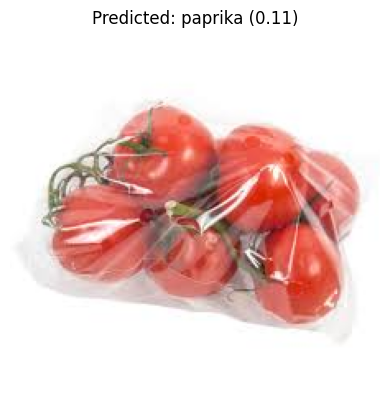

In [11]:
## Inference - Test images on model to see model accuracy ##
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the CNN Model (same architecture as in training)
class CNNModel(torch.nn.Module):
    def __init__(self, num_classes, hidden_layers=3):
        super(CNNModel, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        classifier_layers = [torch.nn.Flatten()]
        input_size = 128 * 16 * 16  # Ensure this matches the output from self.features
        for _ in range(hidden_layers):
            classifier_layers.append(torch.nn.Linear(input_size, 128))
            classifier_layers.append(torch.nn.ReLU())
            classifier_layers.append(torch.nn.Dropout(0.5))
            input_size = 128
        classifier_layers.append(torch.nn.Linear(128, num_classes))

        self.classifier = torch.nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Load the trained model
def load_model(model_path, device):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Extract metadata
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']
    hidden_layers = checkpoint.get('hidden_layers', 3)  # Default to 3 if not present

    # Rebuild model and load state_dict
    model = CNNModel(num_classes=num_classes, hidden_layers=hidden_layers)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, class_names

# Preprocess the input image
def preprocess_image(image, device):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Predict the class of the image
def predict_image(image, model, class_names, device):
    image_tensor = preprocess_image(image, device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        prob, predicted_class = torch.max(probabilities, 1)
    return class_names[predicted_class.item()], prob.item()

# Display the image with the predicted class
def display_image_with_prediction(image, predicted_class, probability):
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({probability:.2f})")
    plt.axis("off")
    plt.show()

# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Get paths from the user or set default paths
    model_path = input("Enter the path to the model (default 'cnn-ds1-model.pth'): ") or "cnn-ds1-model.pth"
    image_path = input("Enter the path to the image: ")

    try:
        # Load the model and class names
        model, class_names = load_model(model_path, device)

        # Open the image
        image = Image.open(image_path).convert("RGB")

        # Predict the class of the image
        predicted_class, probability = predict_image(image, model, class_names, device)
        print(f"The predicted class is: {predicted_class} with probability {probability:.2f}")

        # Display the image with the prediction
        display_image_with_prediction(image, predicted_class, probability)

    except FileNotFoundError as e:
        print(f"File not found: {e.filename}")
    except RuntimeError as e:
        print(f"Runtime error during inference: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
